In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats
import numpy as np
import csv
from collections import defaultdict, Counter
import json
from scipy.stats import zscore, mannwhitneyu
sns.set(style="whitegrid")

### Comparison of word choice metrics

In [2]:
root = '/mnt/data0/lucy/ingroup_lang/'

In [3]:
count_cut_off = 0
pmi_cut_off = 0.3034868476499491
tfidf_cut_off = 3.0837233757223963
sensepmi_cut_off = 0.17994827737953864
agpmi_cut_off = 0.1744524242466855

In [4]:
def metric_correlation(metric1, metric2, sr_f, path1, path2, plot=True): 
    df1 = pd.read_csv(path1 + sr_f, engine='python')
    df2 = pd.read_csv(path2 + sr_f, engine='python')
    df = pd.merge(df1, df2, on='word', how='outer')
    corr = stats.pearsonr(df[metric1], df[metric2])
    if plot: 
        print(corr)
        p = sns.scatterplot(x=metric1, y=metric2, data=df)
        plt.title(sr_f)
        plt.show()
    return corr
def metric_correlation_generic(metric1, metric2, path1, path2, join_on, title, ylog=False, ylim=None): 
    df1 = pd.read_csv(path1, engine='python')
    df2 = pd.read_csv(path2, engine='python')
    df = pd.merge(df1, df2, on=join_on, how='outer')
    p = sns.scatterplot(x=metric1, y=metric2, data=df)
    print(stats.pearsonr(df[metric1], df[metric2]))
    if ylog: 
        plt.yscale('log')
    if ylim: 
        plt.ylim(ylim)
    plt.title(title)
    plt.show()

(0.5772042181278609, 0.0)


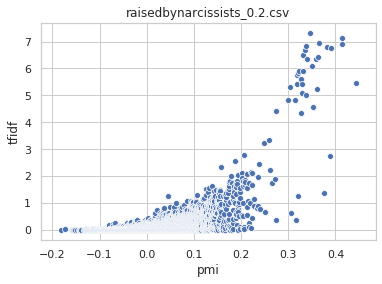

(0.5772042181278609, 0.0)

In [5]:
metric_correlation('pmi', 'tfidf', 'raisedbynarcissists_0.2.csv', root + 'logs/norm_pmi/', root + 'logs/tfidf/')

(0.511688276912473, 0.0)


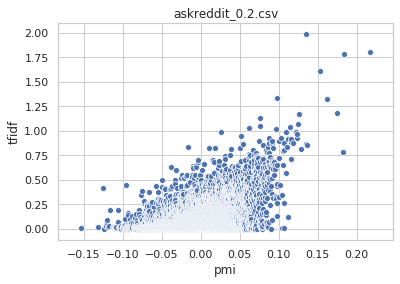

(0.511688276912473, 0.0)

In [6]:
metric_correlation('pmi', 'tfidf', 'askreddit_0.2.csv', root + 'logs/norm_pmi/', root + 'logs/tfidf/')

In [7]:
corrs = []
for sr in os.listdir(root + 'logs/norm_pmi/'): 
    corr = metric_correlation('pmi', 'tfidf', sr, 
                              root + 'logs/norm_pmi/', root + 'logs/tfidf/', plot=False)
    corrs.append(corr[0])
print(np.mean(corrs))
print(np.var(corrs))

0.7425736775110013
0.006726431837084134


### Comparison of user metrics

(0.21364493754601233, 2.687074328899955e-06)


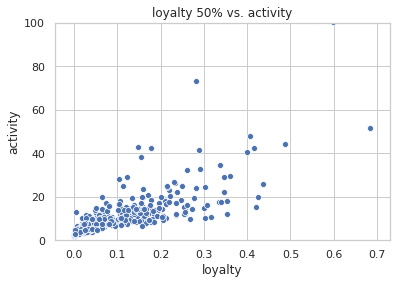

In [8]:
# for different thresholds, the pearson corr is still around 0.22
# however there are subreddits with similar levels of activity but different loyalty
threshold = 50
commentor_path1 = root + 'logs/commentor_loyalty_'+str(threshold)
commentor_path2 = root + 'logs/commentor_activity'
metric_correlation_generic('loyalty', 'activity', commentor_path1, commentor_path2, 
                           'subreddit', 'loyalty ' + str(threshold) + '% vs. activity', ylim=(0,100))

(0.49697112535542687, 6.193748698530485e-31)


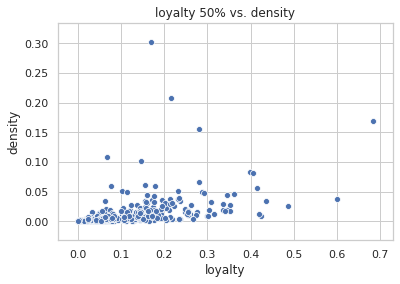

In [9]:
threshold = 50
commentor_path1 = root + 'logs/commentor_loyalty_'+str(threshold)
commentor_path2 = root + 'logs/commentor_density'
metric_correlation_generic('loyalty', 'density', commentor_path1, commentor_path2, 
                           'subreddit', 'loyalty ' + str(threshold) + '% vs. density')

## User analysis (activity, loyalty, centrality)

In [5]:
with open(root + 'logs/user_sr.json', 'r') as infile: 
    user_sr = json.load(infile) # user : [list of subreddits]
# sr : set of loyal users
loyal_users = defaultdict(set) 
for user in user_sr: 
    mc = Counter(user_sr[user]).most_common()
    for i, tup in enumerate(mc): 
        if float(tup[1]) / len(user_sr[user]) >= 0.5: 
            loyal_users[tup[0]].add(user)
        else: 
            break

In [6]:
with open(root + 'logs/sr_user_counts.json', 'r') as infile: 
    # user activity
    # sr : {user : number of comments in that sr}
    sr_user_counts = json.load(infile)

In [7]:
with open(root + 'logs/user_centralities.json', 'r') as infile: 
    # sr : {user : centrality}
    sr_user_centrality = json.load(infile)

In [8]:
with open(root + 'logs/base_user_scores.json', 'r') as infile: 
    user_scores = json.load(infile)
with open(root + 'logs/pmi_user_scores.json', 'r') as infile: 
    pmi_user_scores = json.load(infile)

In [9]:
def attribute_vs_scores(other_dict, score_dict, ylabel, xlog=True):
    corrs = []
    for sr in sr_user_counts: 
        x = [] 
        y = []
        z = []
        for user in sorted(other_dict[sr]): 
            x.append(other_dict[sr][user])
            y.append(score_dict[sr][user])
        if all(v == 0 for v in y): continue
        corr = stats.pearsonr(x, y)
        if sr == 'overwatch':
            plt.scatter(x, y, alpha=0.1)
            if xlog:
                plt.xscale('log')
            plt.xlabel(ylabel)
            plt.ylabel("probability")
        corrs.append(corr[0])
    return corrs

-0.0009147499245032989
-0.0003493566026496967


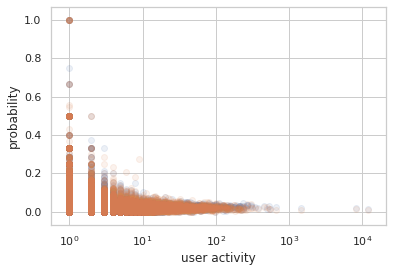

In [10]:
sense_corrs = attribute_vs_scores(sr_user_counts, user_scores, "user activity")
print(np.mean(sense_corrs))
type_corrs = attribute_vs_scores(sr_user_counts, pmi_user_scores, "user activity")
print(np.mean(type_corrs))

-0.02155967862159392
-0.020054175933137977


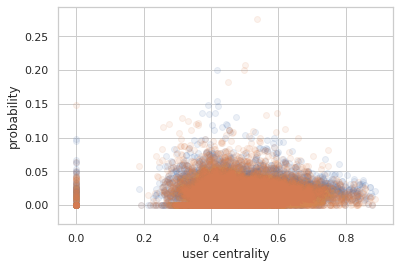

In [11]:
sense_corrs = attribute_vs_scores(sr_user_centrality, user_scores, "user centrality", xlog=False)
print(np.mean(sense_corrs))
type_corrs = attribute_vs_scores(sr_user_centrality, pmi_user_scores, "user centrality", xlog=False)
print(np.mean(type_corrs))

In [16]:
def loyalty_vs_scores(score_dict): 
    pvalues = []
    for sr in sr_user_counts: 
        x = [] 
        y = []
        for user in sorted(score_dict[sr]): 
            if user in loyal_users[sr]: 
                x.append(score_dict[sr][user])
            else: 
                y.append(score_dict[sr][user])
        if all(v == 0 for v in x): continue
        p = mannwhitneyu(x, y, alternative='greater')[1]
        pvalues.append(p < 0.001)
    print("significant count:", pvalues.count(True))
    print("non-significant count:", pvalues.count(False))
loyalty_vs_scores(user_scores)
loyalty_vs_scores(pmi_user_scores)
#plt.hist(x, label="loyal", alpha=0.2, density=True, range=[0, 0.1])
#plt.hist(y, label="unloyal", alpha=0.2, density=True, range=[0, 0.1])
#plt.legend()

significant count: 442
non-significant count: 23
465
significant count: 425
non-significant count: 10
435


### Word choice vs. word frequency

In [18]:
def metric_vs_frequency(metric_name, path, n): 
    # generate plot for 10 subreddits
    i = 0
    for f in os.listdir(path): 
        if not f.endswith('.csv'): continue
        df = pd.read_csv(path + f, engine='python')
        df = df[df['count'] > count_cut_off]
        p = sns.scatterplot(x='count', y=metric_name, data=df)
        p.figure.get_axes()[0].set_xscale('log')
        plt.title(f)
        plt.show()
        i += 1
        if i > n: break

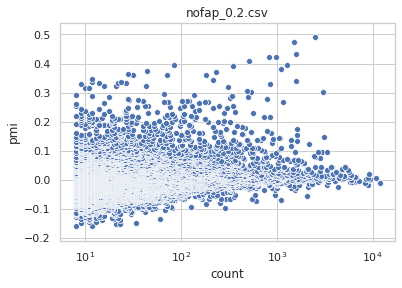

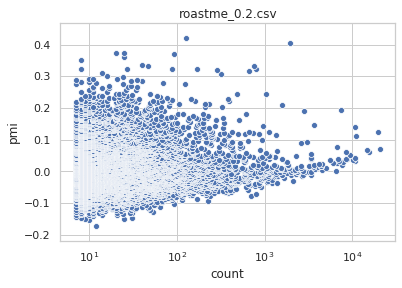

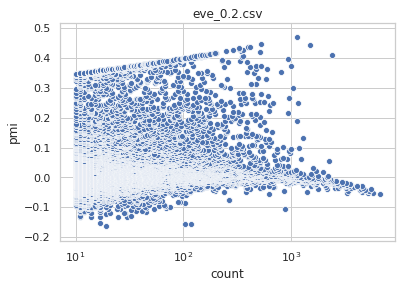

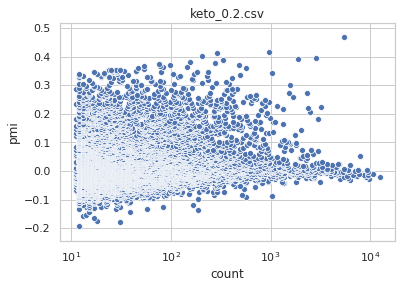

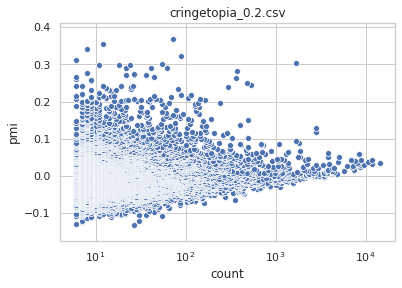

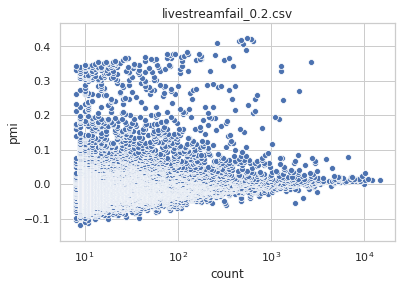

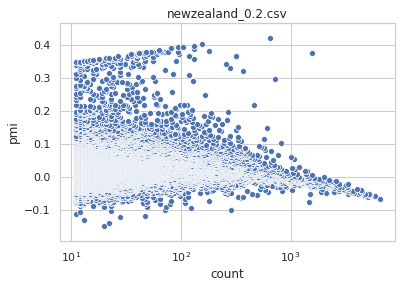

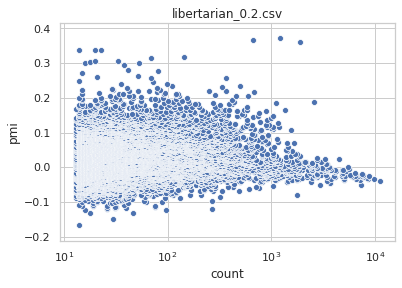

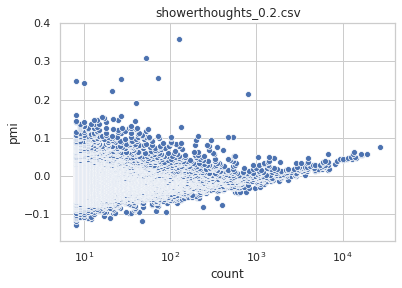

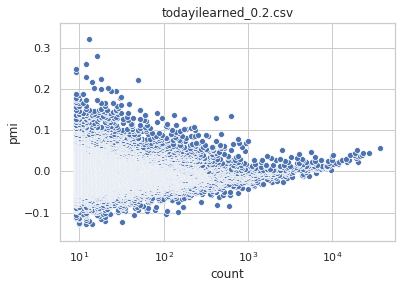

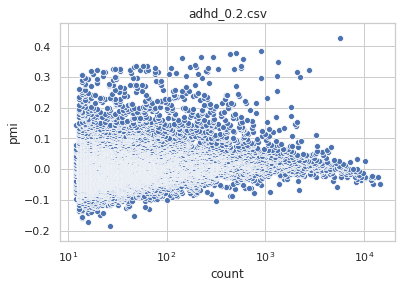

In [19]:
metric_vs_frequency('pmi', root + 'logs/norm_pmi/', 10)

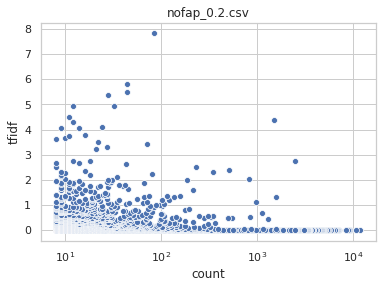

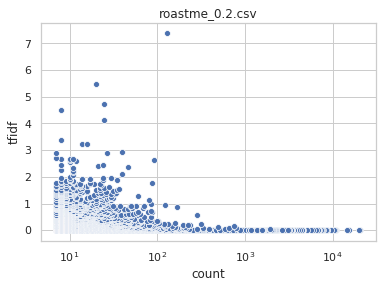

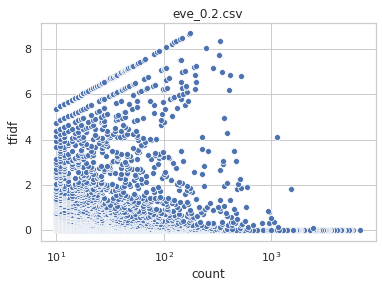

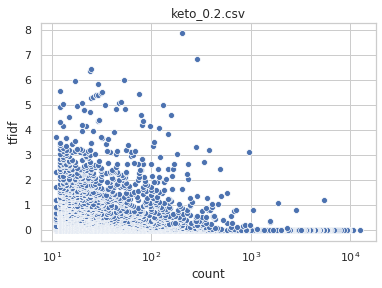

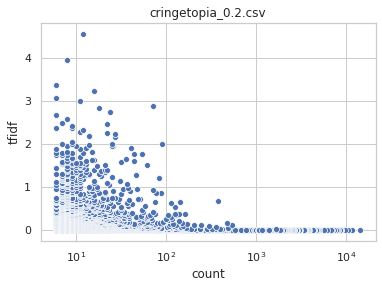

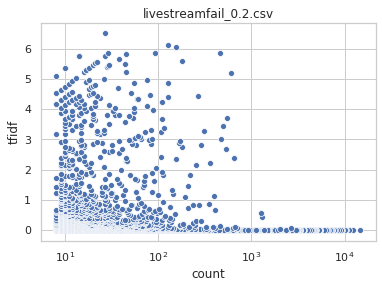

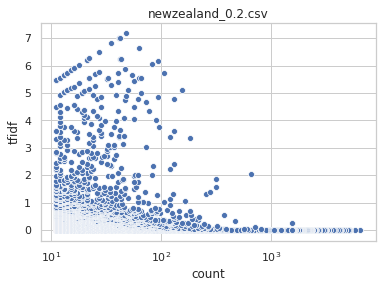

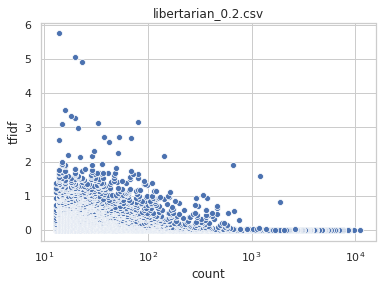

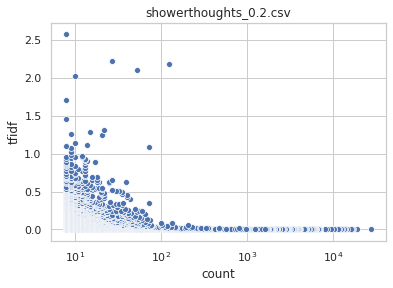

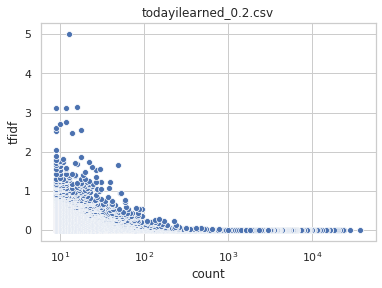

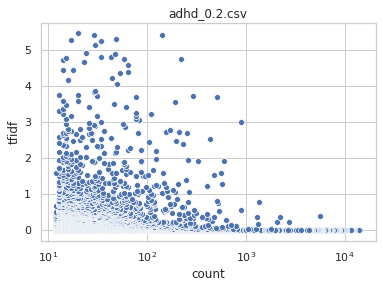

In [20]:
metric_vs_frequency('tfidf', root + 'logs/tfidf/', 10)

In [21]:
def single_metric_vs_frequency(sr_f, metric_name, path): 
    df = pd.read_csv(path + sr_f, engine='python')
    df = df[df['count'] > count_cut_off]
    p = sns.scatterplot(x='count', y=metric_name, data=df)
    p.figure.get_axes()[0].set_xscale('log')
    plt.title(sr_f)
    plt.show()

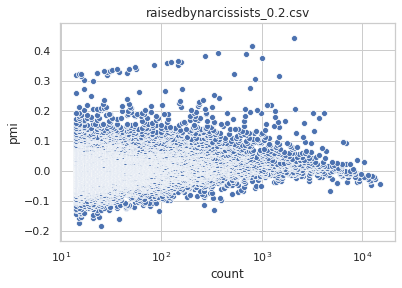

In [22]:
# Look at a single subreddit
single_metric_vs_frequency('raisedbynarcissists_0.2.csv', 'pmi', root + 'logs/norm_pmi/')

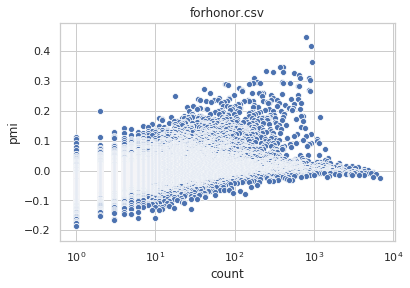

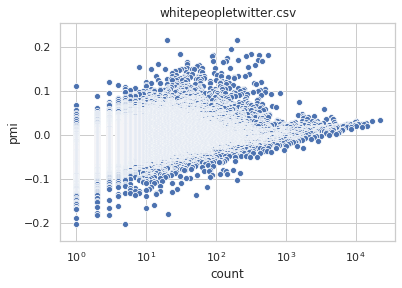

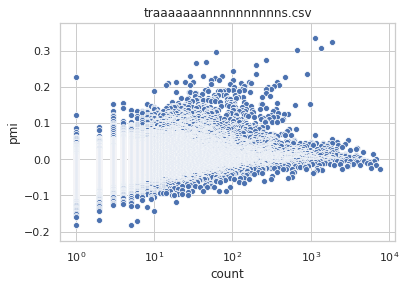

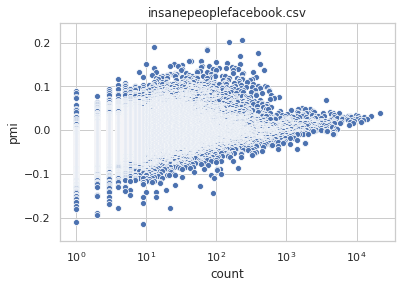

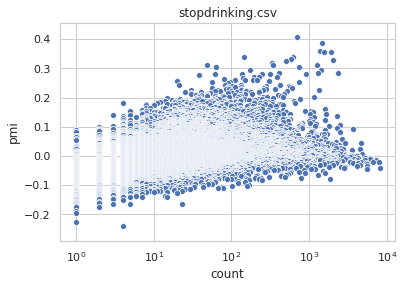

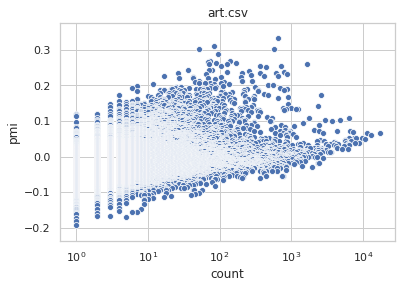

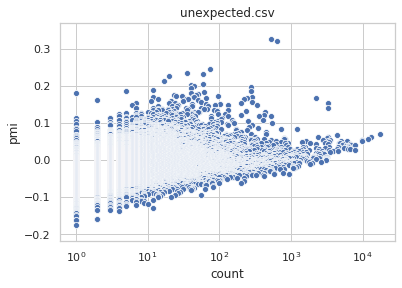

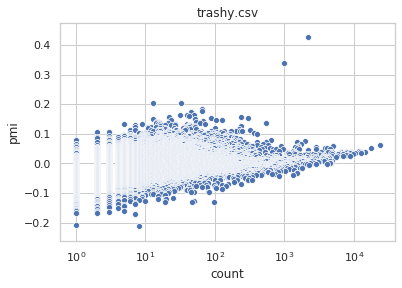

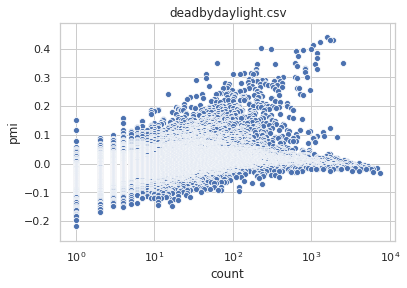

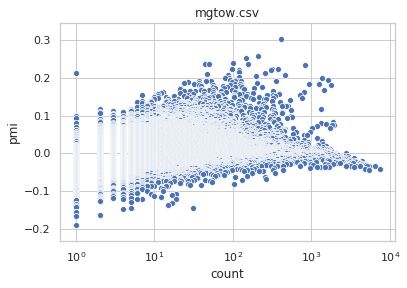

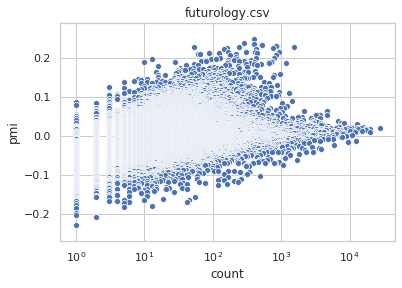

In [23]:
# sense pmi vs sense frequency
metric_vs_frequency('pmi', root + 'logs/base_sense_pmi/', 10)

### Histogram of word choice values

In [24]:
def word_choice_hist(metric_name, path, n): 
    i = 0
    for f in os.listdir(path): 
        if not f.endswith('.csv'): continue
        df = pd.read_csv(path + f, engine='python')
        df = df[df['count'] > count_cut_off]
        p = sns.distplot(a=df[metric_name], kde=False)
        plt.yscale('log')
        plt.ylabel('# of words')
        plt.title(f)
        plt.show()
        i += 1
        if i > n: break

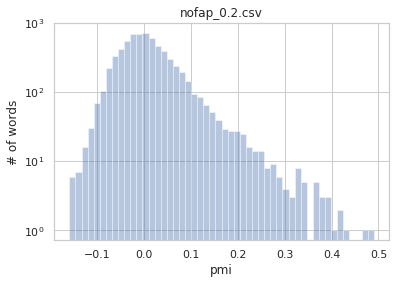

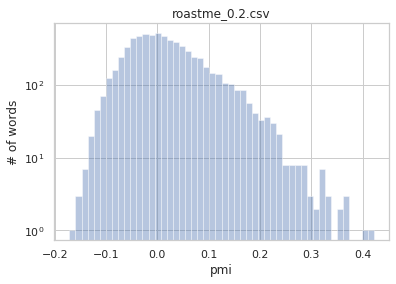

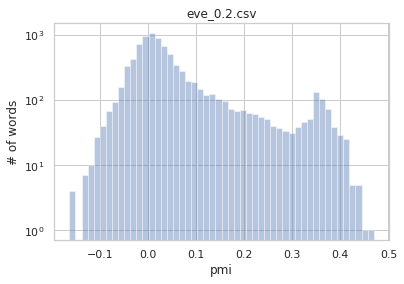

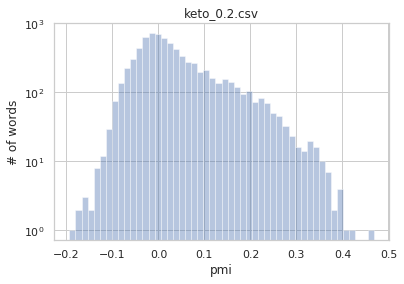

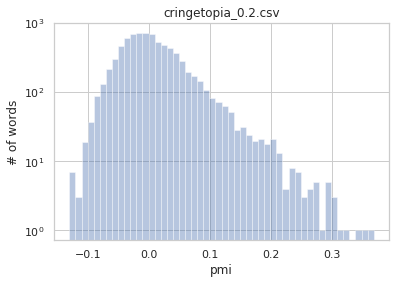

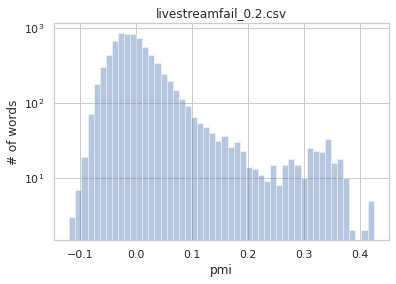

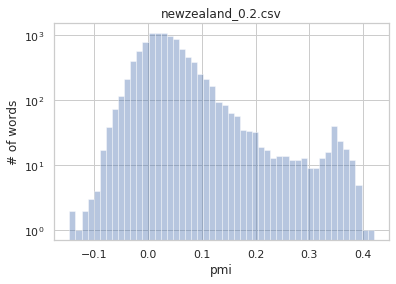

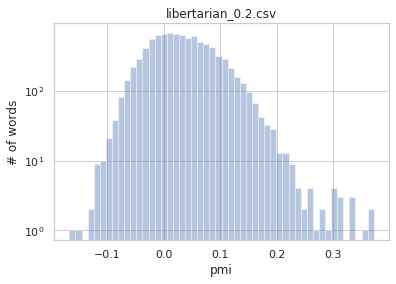

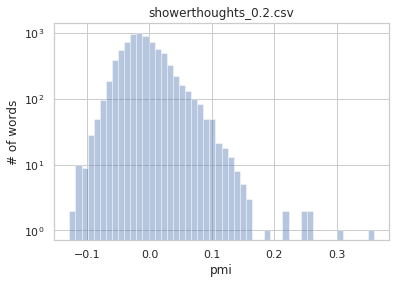

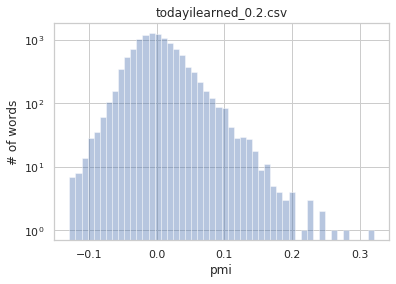

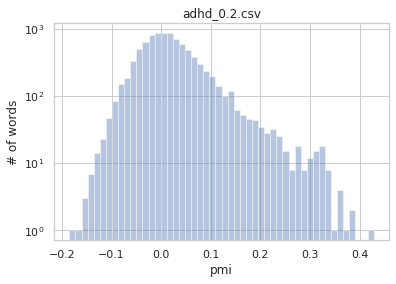

In [25]:
word_choice_hist('pmi', root+'/logs/norm_pmi/', 10)

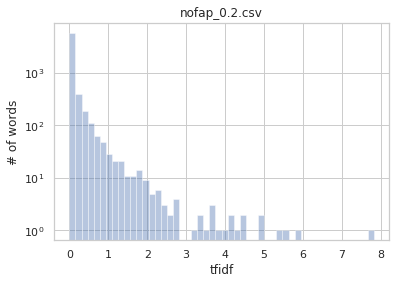

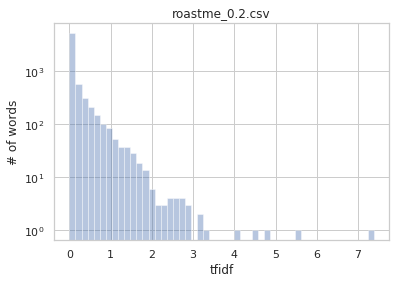

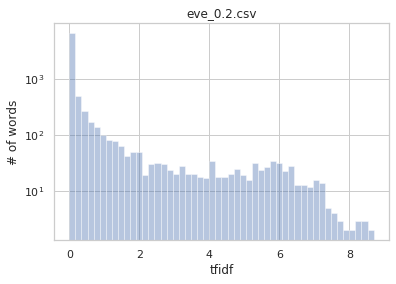

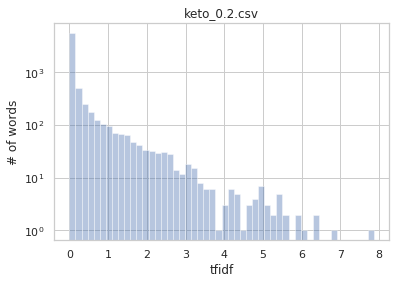

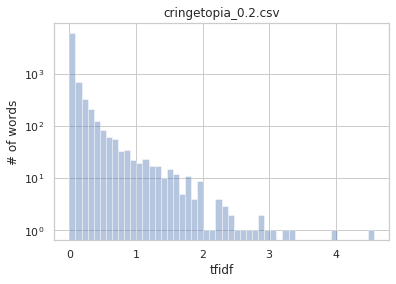

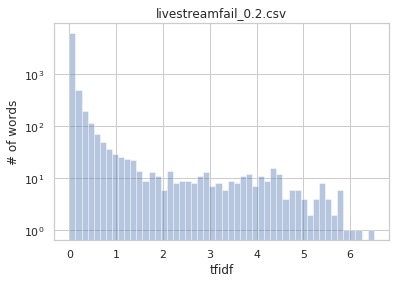

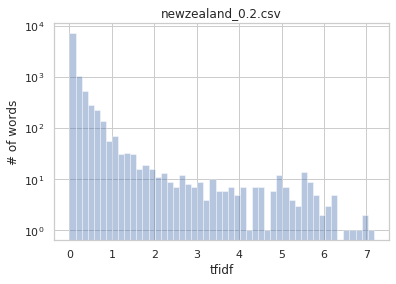

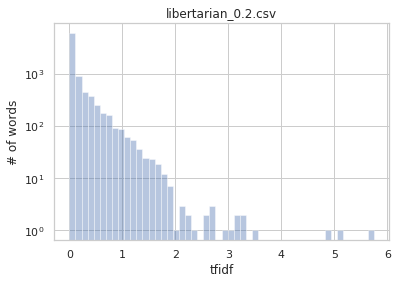

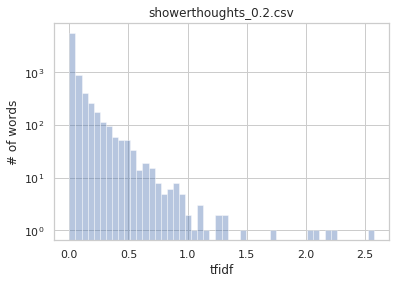

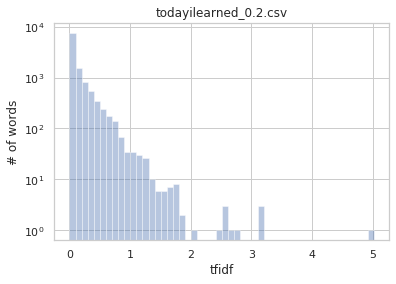

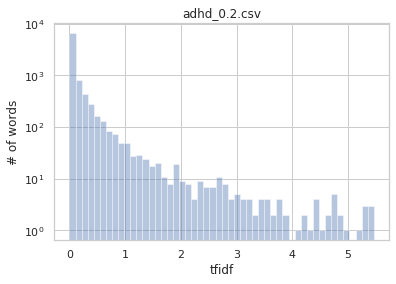

In [26]:
word_choice_hist('tfidf', root+'/logs/tfidf/', 10)

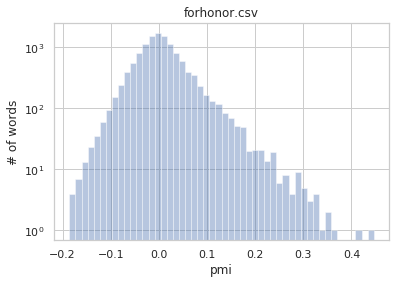

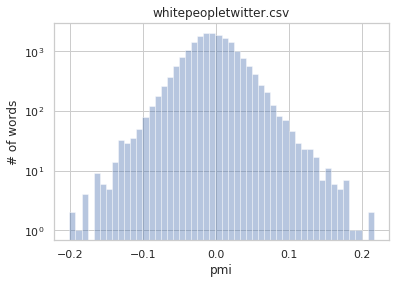

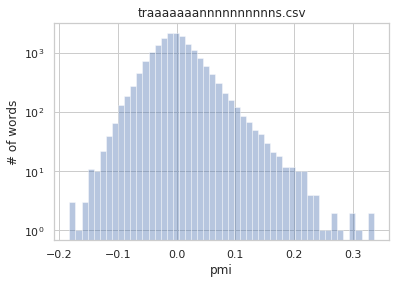

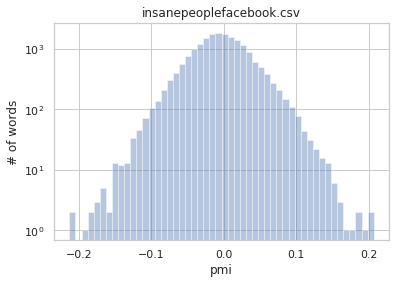

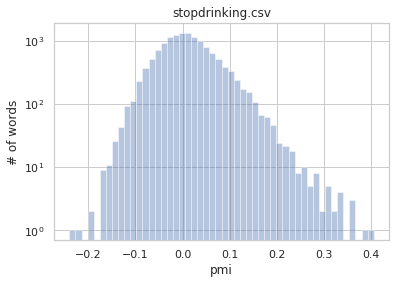

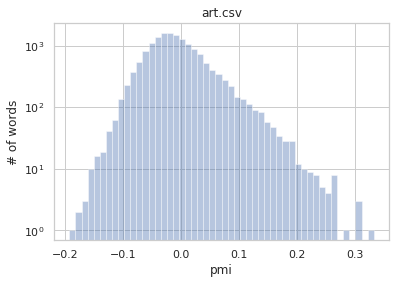

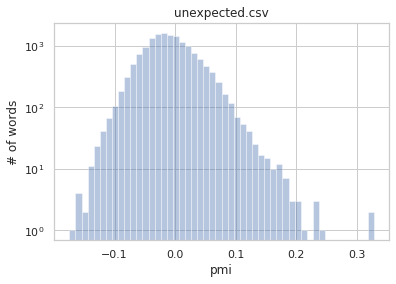

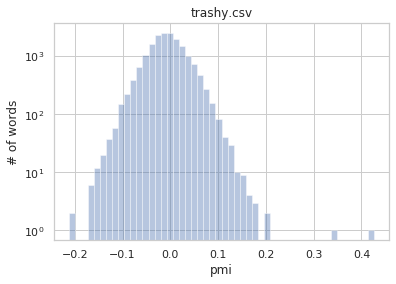

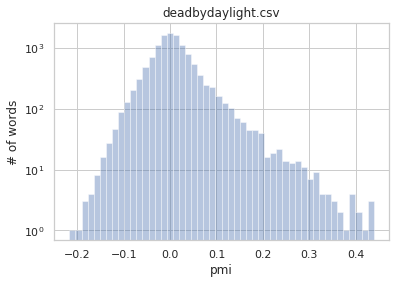

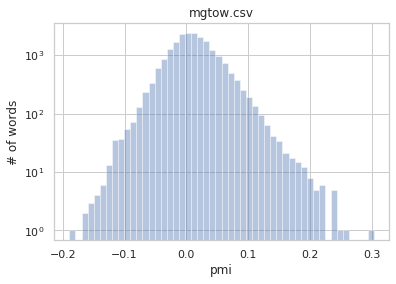

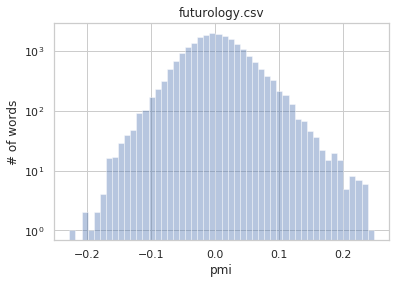

In [27]:
word_choice_hist('pmi', root+'/logs/base_sense_pmi/', 10)

### Most and Least Sociolect-y

In [28]:
from collections import Counter

In [29]:
def most_and_least(metric_name, path, cut_off): 
    score_dict = Counter()
    suffix = '_0.2.csv'
    for f in os.listdir(path): 
        if not f.endswith('.csv'): continue
        subreddit = f.replace(suffix, '').replace('.csv', '')
        df = pd.read_csv(path + f, engine='python')
        notable_words = df[df['count'] > count_cut_off]
        num_words = len(notable_words)
        high_val_df = notable_words[notable_words[metric_name] > cut_off]
        num_high_val = len(high_val_df)
        score = num_high_val / float(num_words)
        score_dict[subreddit] = score
    mc = score_dict.most_common()
    print("TOP")
    print(mc[:10])
    print("BOTTOM")
    print(mc[-10:])

In [30]:
most_and_least('pmi', root + '/logs/norm_pmi/', pmi_cut_off)

TOP
[('transcribersofreddit', 0.41013351591920577), ('pokemontrades', 0.1756440281030445), ('counting', 0.11636001989060168), ('jailbreak', 0.11515490854796566), ('indiaspeaks', 0.10942995011041139), ('fantasybaseball', 0.10781990521327015), ('yugioh', 0.10555627509389975), ('edh', 0.10415210401230253), ('mariomaker', 0.08982111363063744), ('summonerswar', 0.08847910675012688)]
BOTTOM
[('whitepeopletwitter', 0.0), ('depression', 0.0), ('funny', 0.0), ('confession', 0.0), ('twoxchromosomes', 0.0), ('confessions', 0.0), ('worldnews', 0.0), ('tooafraidtoask', 0.0), ('conservative', 0.0), ('outoftheloop', 0.0)]


In [31]:
most_and_least('most_pmi', root + '/logs/base_most_sense_pmi/', sensepmi_cut_off)

TOP
[('fakecollegefootball', 0.13448275862068965), ('market76', 0.12612612612612611), ('counting', 0.11982570806100218), ('truefmk', 0.11419753086419752), ('sub4sub', 0.10378510378510379), ('fantasybaseball', 0.10360075805432722), ('massivecock', 0.10288386593920498), ('rocketleagueexchange', 0.10286103542234333), ('cooking', 0.09739866908650938), ('pokemontrades', 0.091493924231594)]
BOTTOM
[('advice', 0.00028145229383619476), ('showerthoughts', 0.00025614754098360657), ('funny', 0.0002300966405890474), ('tooafraidtoask', 0.00022512381809995497), ('interestingasfuck', 0.00022232103156958648), ('news', 0.0), ('blackpeopletwitter', 0.0), ('todayilearned', 0.0), ('nostupidquestions', 0.0), ('askreddit', 0.0)]


### Correlation between sense and type

In [5]:
from scipy.stats import spearmanr, pearsonr

SpearmanrResult(correlation=0.7855370325541756, pvalue=1.930200515099276e-100)
(0.49830384614913165, 4.074844284385834e-31)


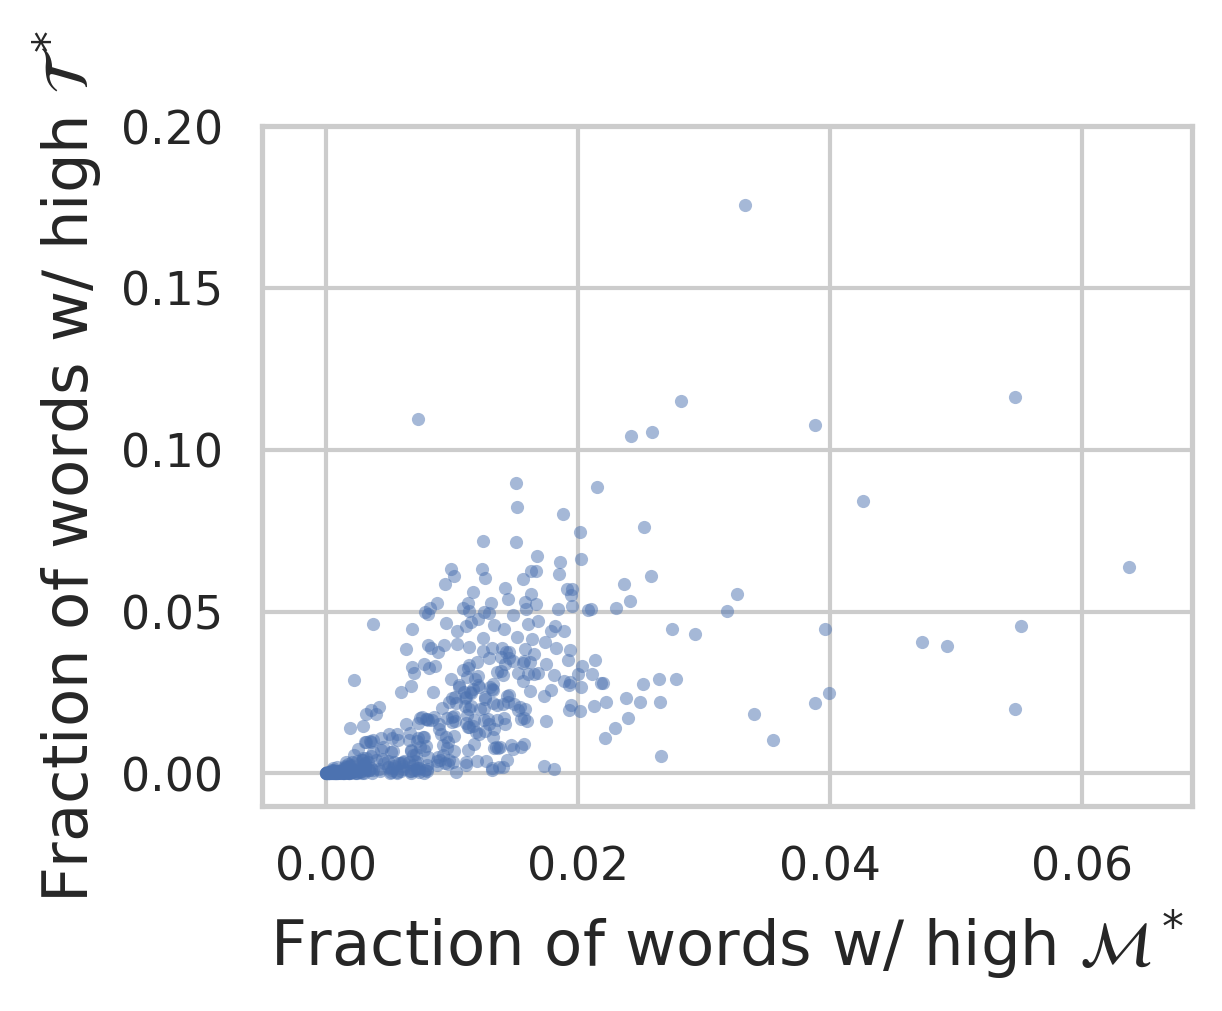

In [6]:
def get_fraction_correlation(): 
    y = []
    x = []
    for f in os.listdir(root + '/logs/base_most_sense_pmi/'): 
        sr = f.replace('.csv', '')
        sense_scores = defaultdict(float)
        vocab_size = 0
        type_count = 0
        sense_count = 0
        with open(root + '/logs/base_most_sense_pmi/' + f, 'r') as infile:
            reader = csv.DictReader(infile)
            for row in reader: 
                w = row['word']
                score = float(row['most_pmi'])
                sense_scores[w] = score
        with open(root + '/logs/norm_pmi/' + sr + '_0.2.csv', 'r') as infile:
            reader = csv.DictReader(infile)
            for row in reader: 
                w = row['word']
                score = float(row['pmi'])
                vocab_size += 1
                if score > pmi_cut_off:  
                    type_count += 1
                if sense_scores[w] > sensepmi_cut_off: 
                    sense_count += 1
        y.append(type_count / float(vocab_size))
        x.append(sense_count / float(vocab_size))
    print(spearmanr(x, y))
    print(pearsonr(x, y))
    plt.figure(figsize=(4, 3), dpi=300)
    plt.scatter(x, y, alpha=0.5, marker='o', linewidths=0.0, s=10)
    plt.ylabel("Fraction of words w/ high $\mathcal{T}^*$", fontsize=15)
    plt.ylim((-0.01, 0.2))
    plt.xlabel("Fraction of words w/ high $\mathcal{M}^*$", fontsize=15)
    plt.show()
get_fraction_correlation()

### Size of community vs word choice

In [17]:
def user_sense_type_plot(commentor_path, sense_cutoff, type_cutoff, xlabel, 
                         xlog=True, xlim=None, ylim=None, turnoffy=False): 
    '''
    Combining type and embedding max sense PMI as the y-axis into one plot 
    '''
    sr_ncoms = pd.read_csv(commentor_path, engine='python').set_index('subreddit').T.to_dict('list')
    y = []
    x = []
    for f in os.listdir(root + '/logs/base_most_sense_pmi/'): 
        sr = f.replace('.csv', '')
        sense_scores = defaultdict(float)
        vocab_size = 0
        sociolect_count = 0
        with open(root + '/logs/base_most_sense_pmi/' + f, 'r') as infile:
            reader = csv.DictReader(infile)
            for row in reader: 
                w = row['word']
                score = float(row['most_pmi'])
                sense_scores[w] = score
        with open(root + '/logs/norm_pmi/' + sr + '_0.2.csv', 'r') as infile:
            reader = csv.DictReader(infile)
            for row in reader: 
                w = row['word']
                score = float(row['pmi'])
                vocab_size += 1
                if score > type_cutoff or sense_scores[w] > sense_cutoff:  
                    sociolect_count += 1
        y.append(sociolect_count / float(vocab_size))
        x.append(sr_ncoms[sr][0])
    plt.figure(figsize=(4, 3), dpi=300)
    plt.scatter(x, y, alpha=0.5, marker='o', linewidths=0.0, s=10)
    if xlog: 
        plt.xscale('log')
    if xlim: 
        plt.xlim(xlim)
    if ylim: 
        plt.ylim(ylim)
    plt.xlabel(xlabel, fontsize=25)
    if turnoffy: 
        plt.tick_params(
            axis='y',          
            which='both',      
            left=False,      
            right=False,         
            labelleft=False) 
    else: 
        plt.yticks(fontsize=15)
        plt.ylabel(r'$\mathcal{F}$', fontsize=30)
    plt.xticks(fontsize=15)
    plt.show()

In [44]:
def community_word_choice(commentor_path, metric_name, path, cut_off, xlabel, scatter=False, 
                               xlog=True, xlim=None, ylim=None): 
    sr_ncoms = pd.read_csv(commentor_path, engine='python').set_index('subreddit').T.to_dict('list')
    suffix = '_0.2.csv'
    y = []
    x = []
    srs = []
    for f in os.listdir(path): 
        if not f.endswith('.csv'): continue
        subreddit = f.replace(suffix, '').replace('.csv', '')
        df = pd.read_csv(path + f, engine='python')
        notable_words = df[df['count'] > count_cut_off]
        num_words = len(notable_words)
        high_val_df = notable_words[notable_words[metric_name] > cut_off]
        num_high_val = len(high_val_df)
        score = num_high_val / float(num_words)
        y.append(score)
        x.append(sr_ncoms[subreddit][0])
        srs.append(subreddit)
    if scatter == True: 
        plt.figure(figsize=(8, 6))
        plt.scatter(x, y, alpha=0.5, marker='.')
        if xlog: 
            plt.xscale('log')
    else: 
        if xlog: 
            x = np.log10(x)
        g = sns.jointplot(x, y, kind='hex')
    if xlim: 
        plt.xlim(xlim)
    if ylim: 
        plt.ylim(ylim)
    plt.ylabel(metric_name + ' > ' + str(cut_off) + ' / total words')
    plt.xlabel(xlabel)
    plt.show()

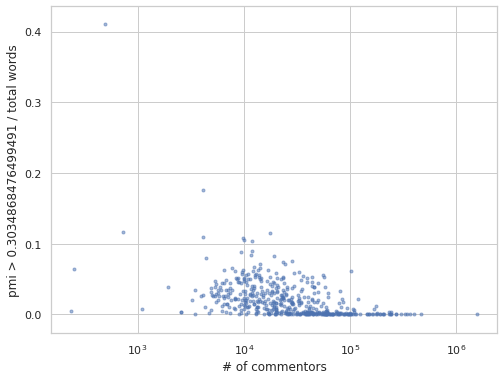

In [45]:
commentor_path = root + 'logs/commentor_counts/part-00000-64b1d705-9cf8-4a54-9c4d-598e5bf9085f-c000.csv'
community_word_choice(commentor_path, 'pmi', root + '/logs/norm_pmi/', pmi_cut_off, 
                           '# of commentors', scatter=True)

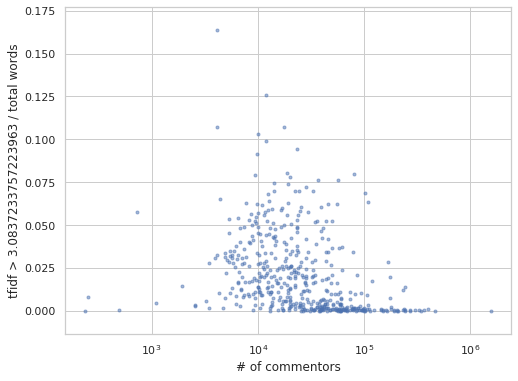

In [46]:
commentor_path = root + 'logs/commentor_counts/part-00000-64b1d705-9cf8-4a54-9c4d-598e5bf9085f-c000.csv'
community_word_choice(commentor_path, 'tfidf', root + '/logs/tfidf/', tfidf_cut_off, 
                           '# of commentors', scatter=True)

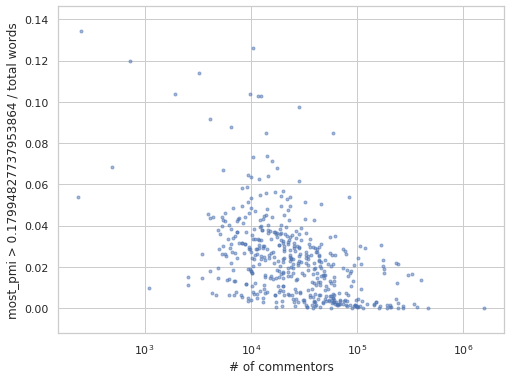

In [47]:
commentor_path = root + 'logs/commentor_counts/part-00000-64b1d705-9cf8-4a54-9c4d-598e5bf9085f-c000.csv'
community_word_choice(commentor_path, 'most_pmi', root + '/logs/base_most_sense_pmi/', sensepmi_cut_off, 
                           '# of commentors', scatter=True)

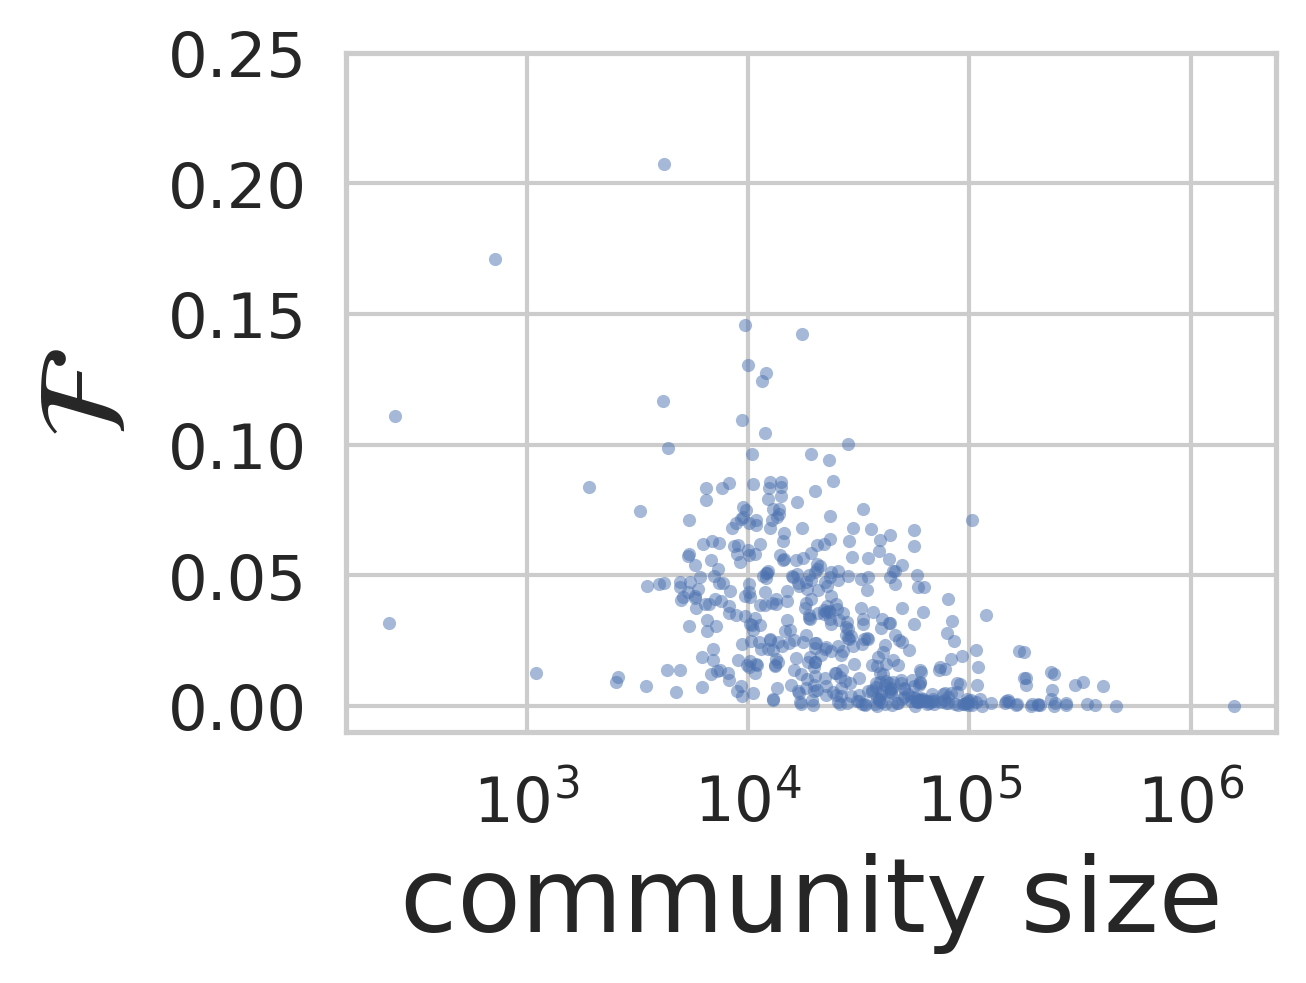

In [18]:
commentor_path = root + 'logs/commentor_counts/part-00000-64b1d705-9cf8-4a54-9c4d-598e5bf9085f-c000.csv'
user_sense_type_plot(commentor_path, sensepmi_cut_off, pmi_cut_off, 'community size', ylim=(-0.01, 0.25))

### Subscribers vs word choice

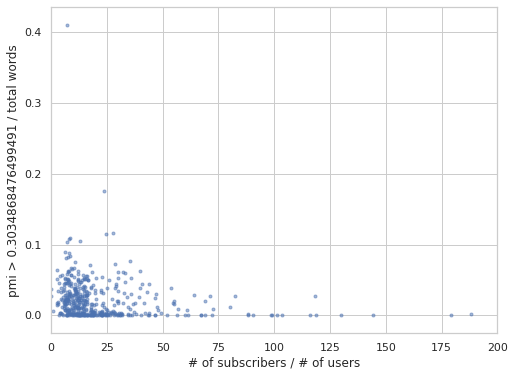

In [49]:
commentor_path = root + 'logs/subscribers_ratio'
community_word_choice(commentor_path, 'pmi', root + '/logs/norm_pmi/', pmi_cut_off, 
                           '# of subscribers / # of users', scatter=True, xlog=False, xlim=(0,200))

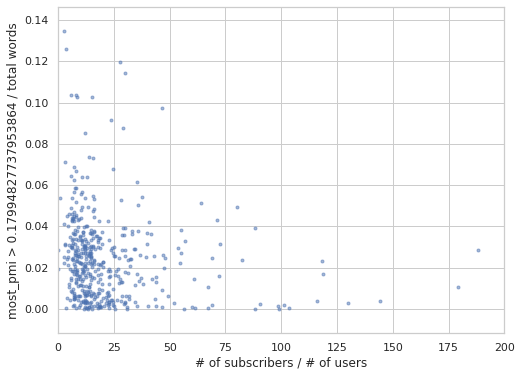

In [50]:
commentor_path = root + 'logs/subscribers_ratio'
community_word_choice(commentor_path, 'most_pmi', root + '/logs/base_most_sense_pmi/', \
                           sensepmi_cut_off,  '# of subscribers / # of users', scatter=True, xlog=False, xlim=(0, 200))

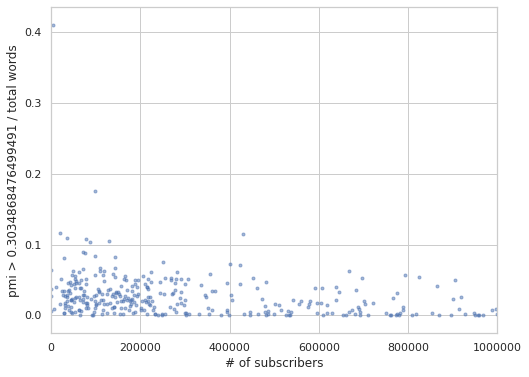

In [51]:
commentor_path = root + 'logs/subscribers'
community_word_choice(commentor_path, 'pmi', root + '/logs/norm_pmi/', pmi_cut_off, 
                           '# of subscribers', scatter=True, xlog=False, xlim=(0, 1000000))

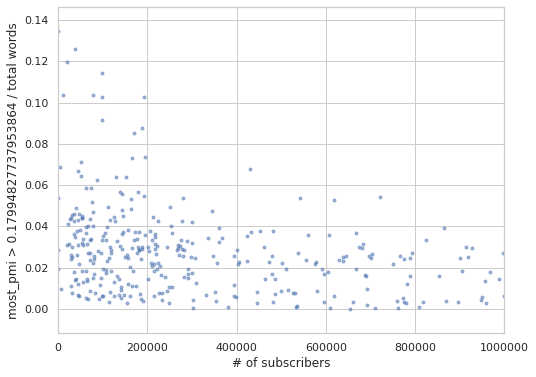

In [52]:
commentor_path = root + 'logs/subscribers'
community_word_choice(commentor_path, 'most_pmi', root + '/logs/base_most_sense_pmi/', \
                           sensepmi_cut_off,  '# of subscribers', scatter=True, xlog=False, xlim=(0, 1000000))

### User activity vs word choice

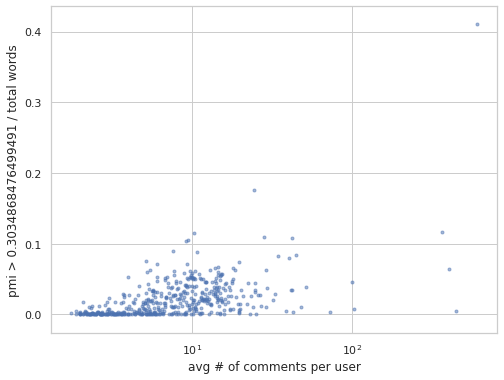

In [54]:
commentor_path = root + 'logs/commentor_activity'
community_word_choice(commentor_path, 'pmi', root + '/logs/norm_pmi/', \
                           pmi_cut_off, 'avg # of comments per user', scatter=True)

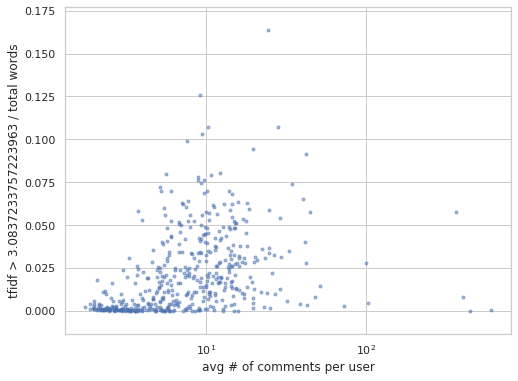

In [55]:
commentor_path = root + 'logs/commentor_activity'
community_word_choice(commentor_path, 'tfidf', root + '/logs/tfidf/', \
                           tfidf_cut_off,  'avg # of comments per user', scatter=True)

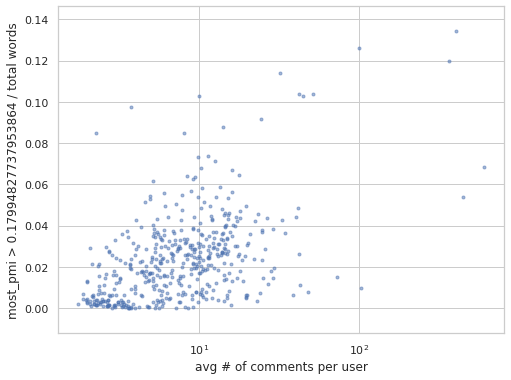

In [56]:
commentor_path = root + 'logs/commentor_activity'
community_word_choice(commentor_path, 'most_pmi', root + '/logs/base_most_sense_pmi/', \
                           sensepmi_cut_off,  'avg # of comments per user', scatter=True)

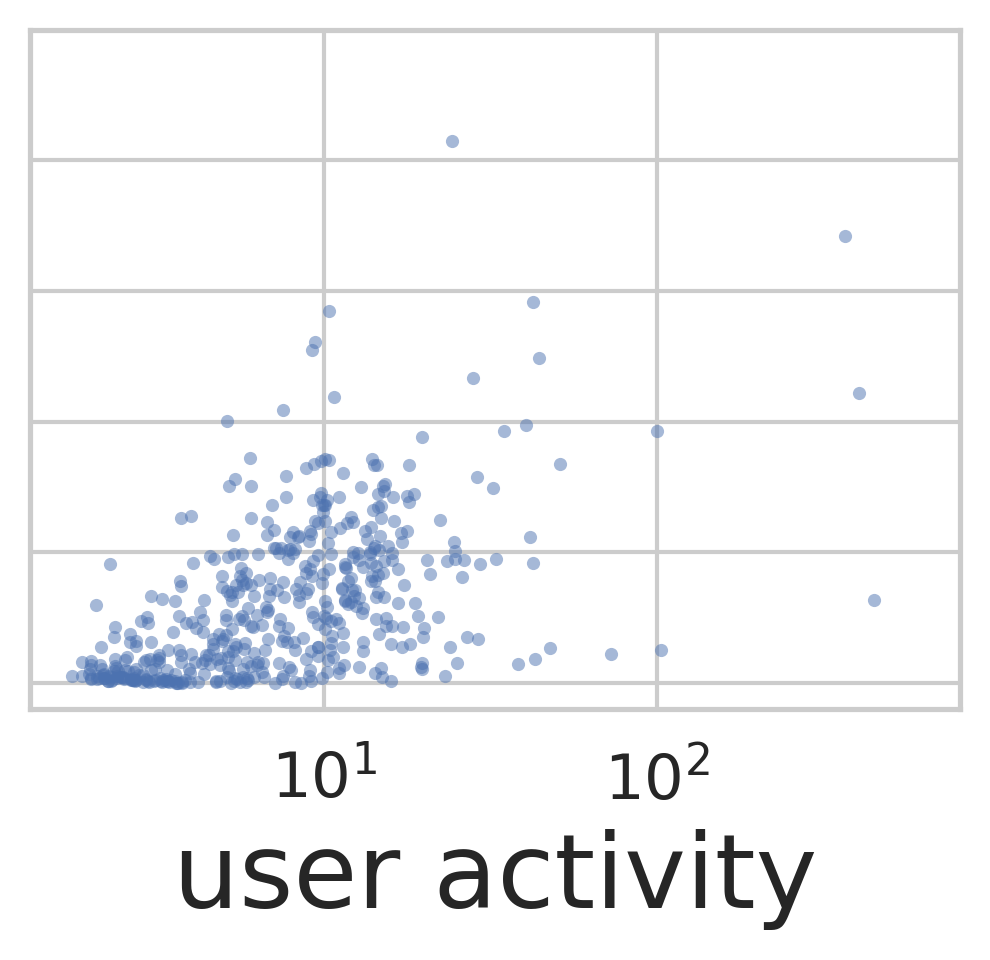

In [19]:
commentor_path = root + 'logs/commentor_activity'
user_sense_type_plot(commentor_path, sensepmi_cut_off, pmi_cut_off, 'user activity', turnoffy=True, ylim=(-0.01, 0.25))

### User loyalty vs word choice

In [21]:
threshold = 50

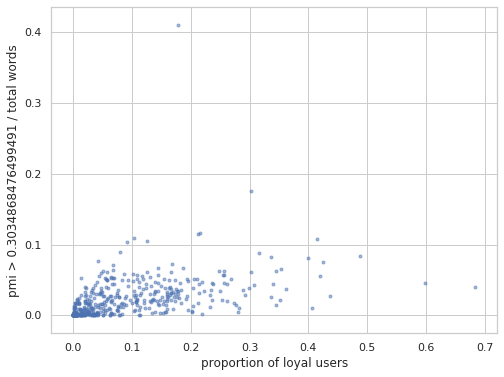

In [59]:
commentor_path = root + 'logs/commentor_loyalty_'+str(threshold)
community_word_choice(commentor_path, 'pmi', root + '/logs/norm_pmi/', \
                           pmi_cut_off, 'proportion of loyal users', scatter=True, xlog=False)

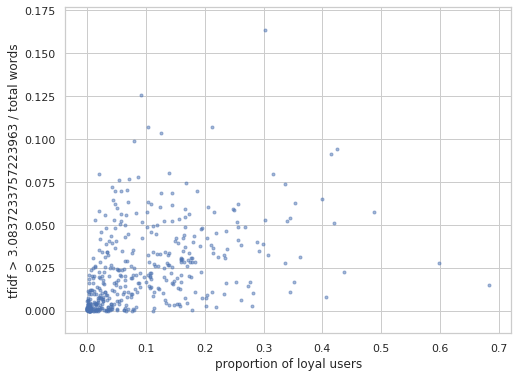

In [60]:
commentor_path = root + 'logs/commentor_loyalty_'+str(threshold)
community_word_choice(commentor_path, 'tfidf', root + '/logs/tfidf/', \
                           tfidf_cut_off,  'proportion of loyal users', scatter=True, xlog=False)

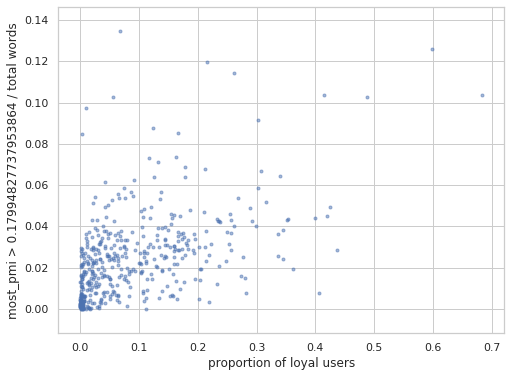

In [61]:
commentor_path = root + 'logs/commentor_loyalty_'+str(threshold)
community_word_choice(commentor_path, 'most_pmi', root + '/logs/base_most_sense_pmi/', \
                           sensepmi_cut_off, 'proportion of loyal users', scatter=True, xlog=False)

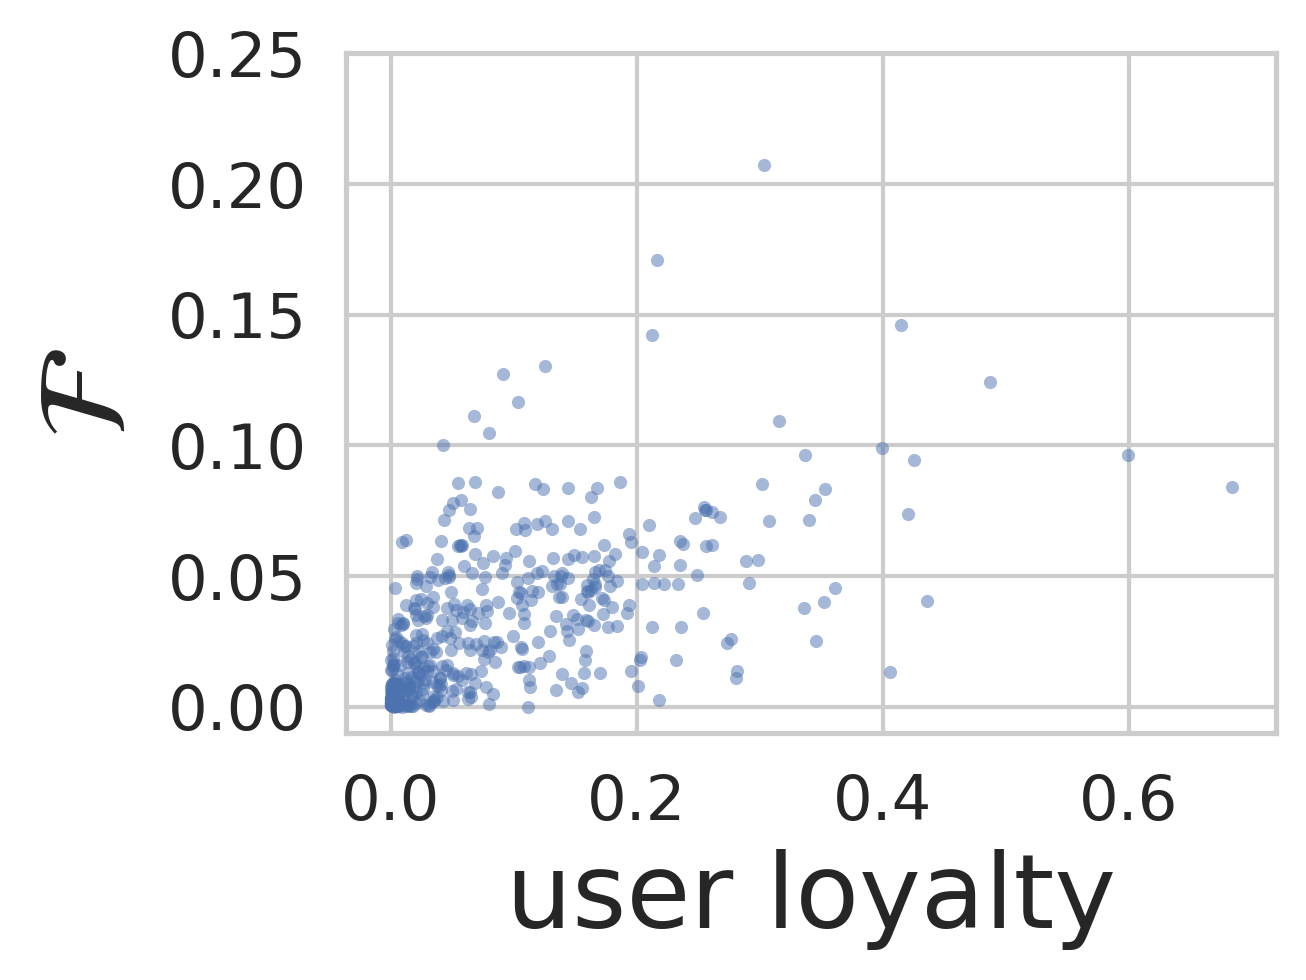

In [22]:
commentor_path = root + 'logs/commentor_loyalty_'+str(threshold)
user_sense_type_plot(commentor_path, sensepmi_cut_off, pmi_cut_off, 'user loyalty', xlog=False, ylim=(-0.01, 0.25))

### User density vs. word choice

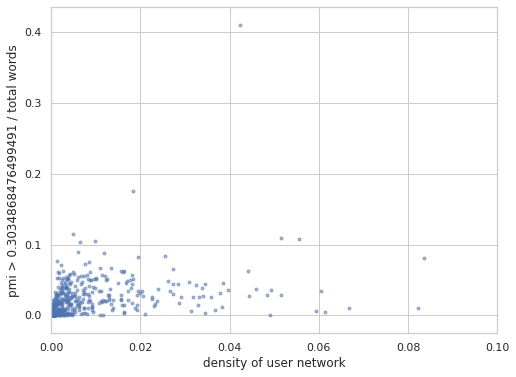

In [63]:
commentor_path = root + 'logs/commentor_density'
community_word_choice(commentor_path, 'pmi', root + '/logs/norm_pmi/', \
                           pmi_cut_off, 'density of user network', scatter=True, 
                           xlog=False, xlim=(0, 0.1))

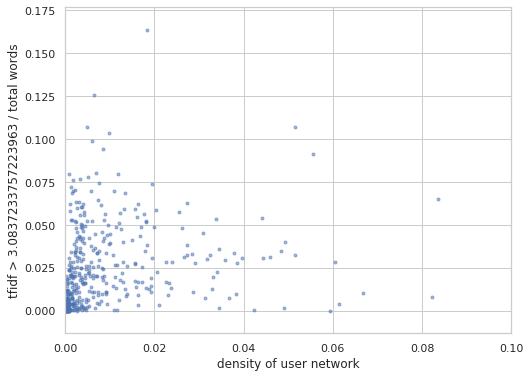

In [64]:
commentor_path = root + 'logs/commentor_density'
community_word_choice(commentor_path, 'tfidf', root + '/logs/tfidf/', \
                           tfidf_cut_off,  'density of user network', scatter=True, 
                           xlog=False, xlim=(0, 0.1))

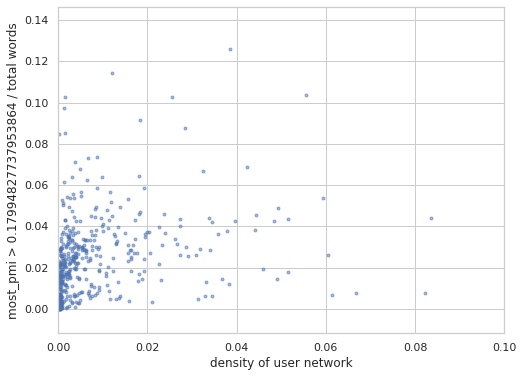

In [65]:
commentor_path = root + 'logs/commentor_density'
community_word_choice(commentor_path, 'most_pmi', root + '/logs/base_most_sense_pmi/', \
                           sensepmi_cut_off, 'density of user network', scatter=True, 
                           xlog=False, xlim=(0, 0.1))

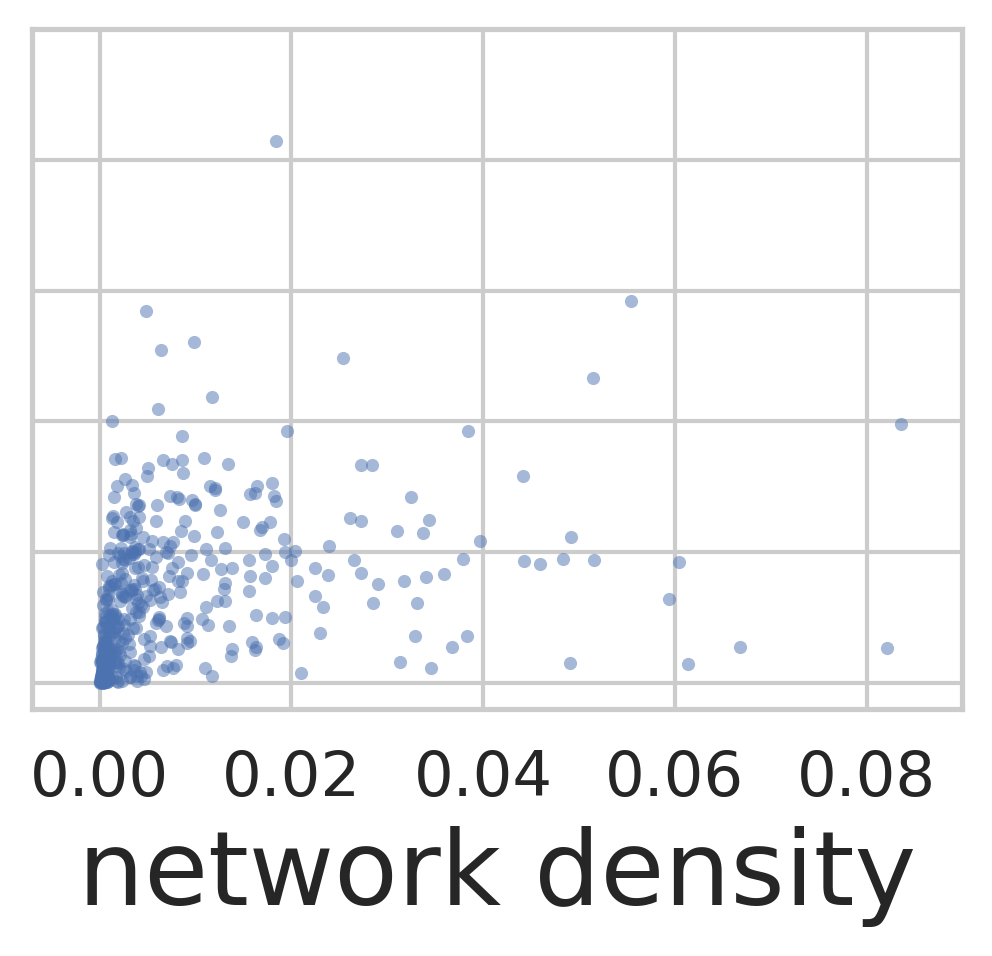

In [23]:
commentor_path = root + 'logs/commentor_density'
user_sense_type_plot(commentor_path, sensepmi_cut_off, pmi_cut_off, 'network density', 
                     xlim=(-0.007, 0.09), xlog=False, turnoffy=True, ylim=(-0.01, 0.25))

## Topics

In [1]:
from collections import defaultdict, Counter

In [2]:
topics = {}
with open('../data/subreddit_topics.txt', 'r') as infile:
    prefix = ''
    curr_title = ''
    for line in infile: 
        if line.startswith('*'): 
            prefix = line.replace('*', '').strip()
            curr_title = prefix
        if line.startswith('~'):
            curr_title = prefix + '_' + line.replace('~', '').strip()
        if line.startswith('/r/'): 
            subreddit = line.replace('/r/', '').strip().split()[0].lower()
            topics[subreddit] = curr_title

In [3]:
reddits = set()
non_english_reddits = set()
with open('../data/non_english_sr.txt', 'r') as inputfile: 
    for line in inputfile: 
        non_english_reddits.add(line.strip().lower())
with open('../data/subreddit_list.txt', 'r') as inputfile: 
    for line in inputfile: 
        sr = line.strip().lower()
        if sr not in non_english_reddits: 
            reddits.add(sr)
topic_counts = Counter()
for sr in reddits: 
    if sr in topics: 
        umbrella = topics[sr].split('_')[0]
        smaller_topic = topics[sr]
        topic = umbrella
        if umbrella in set(['Entertainment', 'Other', 'Lifestyle']): 
            topic = smaller_topic
        topic_counts[topic] += 1
topic_assignments = {}
for sr in reddits:
    if sr in topics: 
        if topic_counts[topics[sr]] >= 10: 
            topic_assignments[sr] = topics[sr]
        elif topic_counts[topics[sr].split('_')[0]] >= 10: 
            topic_assignments[sr] = topics[sr].split('_')[0]
        else: 
            topic_assignments[sr] = 'Other'
    else: 
        topic_assignments[sr] = 'Other'

In [9]:
with open(root + 'logs/topic_assignments.json', 'w') as outfile:
    json.dump(topic_assignments, outfile)

In [10]:
print(set(topics.values()))

{'Hobbies/Occupations_Tech Related', 'Lifestyle_Communities', 'Entertainment_Games', 'Hobbies/Occupations_Photography/Film', 'General Content_Videos', 'Lifestyle_Exercise/Health', 'Educational_Environment', 'Entertainment_TV', 'Hobbies/Occupations_Arts/Writing', 'Animals', 'Entertainment_Video games', 'Entertainment_Internet/Apps', 'Entertainment_Anime/Manga', 'Discussion_AMA', 'Other_Weird Feelings/Categorize Later', 'Humor_General Humor', 'Educational_Law', 'Other_Shitty', 'Hobbies/Occupations_Aquariums', 'Other_Cute', 'Other_News/Politics', 'Lifestyle_Fashion/Beauty', 'Hobbies/Occupations_General', 'Other_Conspiracy', 'Hobbies/Occupations_Music', 'Other_Visually Appealing', 'Humor_Memes/Rage comics', 'Other_Nature', 'Other_Mind blowing', 'Hobbies/Occupations_Planes', 'Discussion_Advice', 'Entertainment_Cosplay', 'Animals_Mammals', 'Entertainment_Music', 'Educational_Math', 'Entertainment_Movies', 'Hobbies/Occupations_Travel', 'Educational_Psychology', 'Discussion_General', 'Lifestyl

In [11]:
topic_remap = {'Hobbies/Occupations':'Hobbies/Occ.', 
               'Entertainment_Video games': 'Video Games', 
               'Entertainment_TV': 'TV', 
               'Other_Disgusting/Angering/Scary/Weird': 'DASW',
               'Other_Cringe': 'Cringe', 
               'Entertainment_Internet/Apps': 'Internet/Apps', 
               'Other_Geography': 'Geography',
               'Lifestyle_Relationships/Sex' : 'Relationships/Sex', 
               'Other': 'Other', 
               'Lifestyle_Technology' : 'Technology',
               'Entertainment_Sports' : 'Sports', 
               'Humor': 'Humor', 
               'Discussion': 'Discussion',
              }
def get_topic_df(metric_name, path, cut_off):
    d = {'scores' : [], 'subreddit': [], 'topic': []}
    for f in os.listdir(path): 
        if not f.endswith('.csv'): continue
        subreddit = f.replace('_0.2.csv', '').replace('.csv', '')
        df = pd.read_csv(path + f, engine='python')
        notable_words = df[df['count'] > count_cut_off]
        num_words = len(notable_words)
        high_val_df = notable_words[notable_words[metric_name] > cut_off]
        num_high_val = len(high_val_df)
        score = num_high_val / float(num_words)
        d['scores'].append(score)
        d['subreddit'].append(subreddit)
        d['topic'].append(topic_remap[topic_assignments[subreddit]])
    return pd.DataFrame(data=d)
def get_topic_df_combined(sense_cutoff, type_cutoff): 
    d = {'scores' : [], 'subreddit': [], 'topic': []}
    for f in os.listdir(root + '/logs/base_most_sense_pmi/'): 
        sr = f.replace('.csv', '')
        sense_scores = defaultdict(float)
        vocab_size = 0
        sociolect_count = 0
        with open(root + '/logs/base_most_sense_pmi/' + f, 'r') as infile:
            reader = csv.DictReader(infile)
            for row in reader: 
                w = row['word']
                score = float(row['most_pmi'])
                sense_scores[w] = score
        with open(root + '/logs/norm_pmi/' + sr + '_0.2.csv', 'r') as infile:
            reader = csv.DictReader(infile)
            for row in reader: 
                w = row['word']
                score = float(row['pmi'])
                vocab_size += 1
                if score > type_cutoff or sense_scores[w] > sense_cutoff:  
                    sociolect_count += 1
        d['scores'].append(sociolect_count / float(vocab_size))
        d['subreddit'].append(sr)
        d['topic'].append(topic_remap[topic_assignments[sr]])
    return pd.DataFrame(data=d)

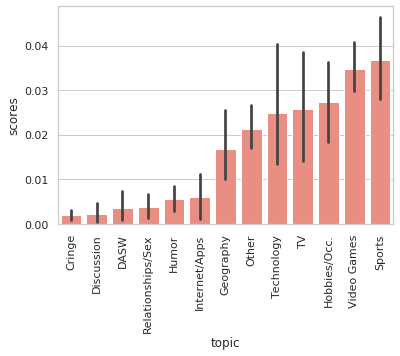

In [12]:
df = get_topic_df('pmi', root + '/logs/norm_pmi/', pmi_cut_off)
result = df.groupby(["topic"])['scores'].aggregate(np.mean).reset_index().sort_values('scores')
sns.barplot(x="topic", y="scores", data=df, order=result['topic'], color='salmon')
plt.xticks(rotation=90)
plt.show()

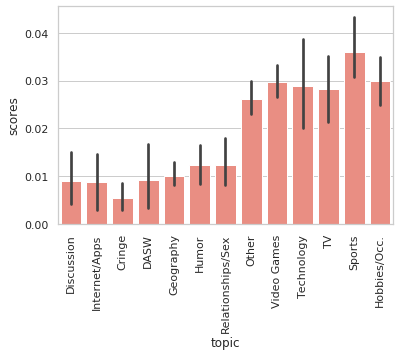

In [13]:
df = get_topic_df('most_pmi', root + '/logs/base_most_sense_pmi/', sensepmi_cut_off)
result = df.groupby(["topic"])['scores'].aggregate(np.median).reset_index().sort_values('scores')
sns.barplot(x="topic", y="scores", data=df, order=result['topic'], color='salmon')
plt.xticks(rotation=90)
plt.show()

In [14]:
df = get_topic_df_combined(sensepmi_cut_off, pmi_cut_off)

In [15]:
df[df['topic'] == 'Hobbies/Occ.'].sort_values('scores')

,scores,subreddit,topic
148,0.004439,assholedesign,Hobbies/Occ.
278,0.005509,atbge,Hobbies/Occ.
382,0.008769,softwaregore,Hobbies/Occ.
5,0.009180,art,Hobbies/Occ.
250,0.014082,idiotsincars,Hobbies/Occ.
178,0.021058,justrolledintotheshop,Hobbies/Occ.
86,0.022724,teslamotors,Hobbies/Occ.
58,0.023030,drawing,Hobbies/Occ.
440,0.024171,cscareerquestions,Hobbies/Occ.
398,0.033186,guns,Hobbies/Occ.


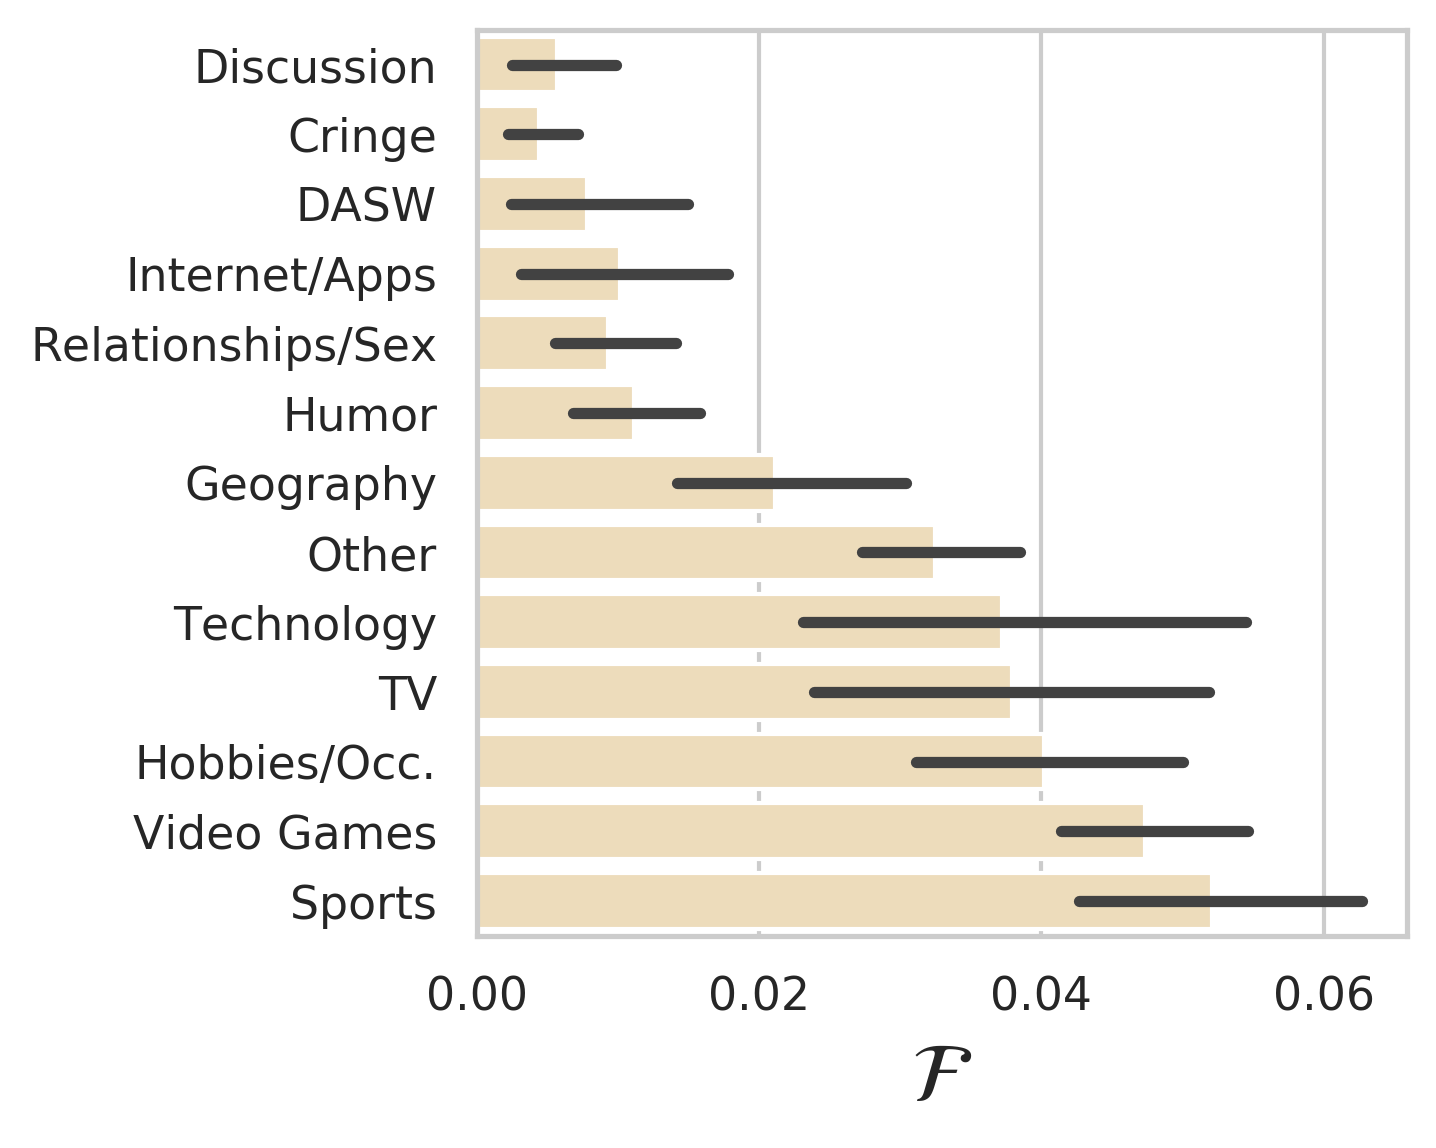

In [16]:
result = df.groupby(["topic"])['scores'].aggregate(np.median).reset_index().sort_values('scores')
plt.figure(figsize=(4, 4), dpi=300)
sns.barplot(x="scores", y="topic", data=df, order=result['topic'], color='wheat')
plt.xlabel(r'$\mathcal{F}$', fontsize=20)
plt.ylabel('')
plt.show()